In [1]:
from pathlib import Path

import numpy as np
from numba import njit, prange

from matplotlib import pyplot as plt

### Load data

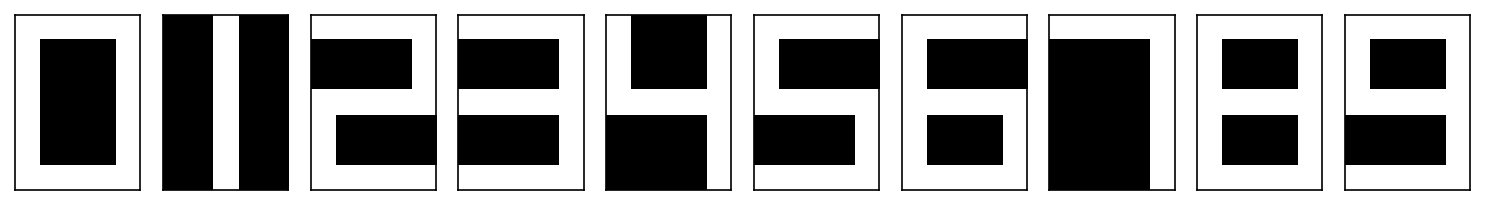

In [2]:
img_shape = (7, 5)
img_size = 35

data_path = Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [3]:
dataset = []
noise_size = 0.25

for i in range(len(data_mtrx)):
    dataset.append(data_mtrx[i])

    for j in range(9):
        noise = np.random.uniform(0, noise_size, img_size)
        dataset.append(data_mtrx[i] + noise)

dataset = np.array(dataset)

### Split dataset to test and train

In [4]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = dataset[idx_test]
x_tarin = dataset[idx_train]

### Define activation functions

In [5]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

### Define model

In [6]:
@njit(fastmath=True)
def grads(xbatch: np.ndarray, Wh: np.ndarray, Bh: np.ndarray, w: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dBh = np.zeros(Bh.shape)

    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in prange(xbatch.shape[0]):
        h = Wh @ xbatch[i] + Bh
        z = sigmoid(h)
        y = w @ z + b

        dw += np.outer(2 * (y - xbatch[i]), z)
        db += 2 * (y - xbatch[i])

        dWh += np.outer(w.T @ (2 * (y - xbatch[i])) * dSigmoid(h), xbatch[i])
        dBh += w.T @ (2 * (y - xbatch[i])) * dSigmoid(h)

    return (dWh, dBh, dw, db)

class Perceptron:
    def __init__(self, nIn: int, nHidden: int, nOut: int) -> None:
        self.nIn = nIn
        self.nHidden = nHidden
        self.nOut = nOut
        
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nHidden, nIn))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nOut, nHidden))
        
        self.Bh: np.ndarray = np.zeros((nHidden,))
        self.b: np.ndarray = np.zeros((nOut,))

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = sigmoid(self.Wh @ x + self.Bh)
        return self.w @ z + self.b

    def loss(self, x: np.ndarray) -> float:        
        xpred = np.array([self.predict(xi) for xi in x])
        h = np.linalg.norm(xpred - x, axis=1)
        return np.mean(h)

    def train(self, xTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dWh, dBh, dw, db = grads(xTrain[batch_idxs], self.Wh, self.Bh, self.w, self.b)

                self.Wh -= lr * dWh
                self.Bh -= lr * dBh
                
                self.w -= lr * dw
                self.b -= lr * db

### Create and train model

In [7]:
nIn = 35
nHidden = 10
nOut = 35

learning_rate = 1e-2
batch_size = 8
max_epoch = 300

model = Perceptron(nIn, nHidden, nOut)

print('untrained loss: ', model.loss(x_test).round(3))

model.train(
    x_tarin,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test).round(3))

untrained loss:  7.735
trained loss:  0.649


### Visualize model predictions

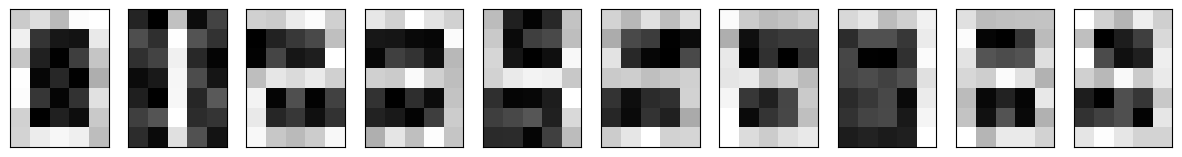

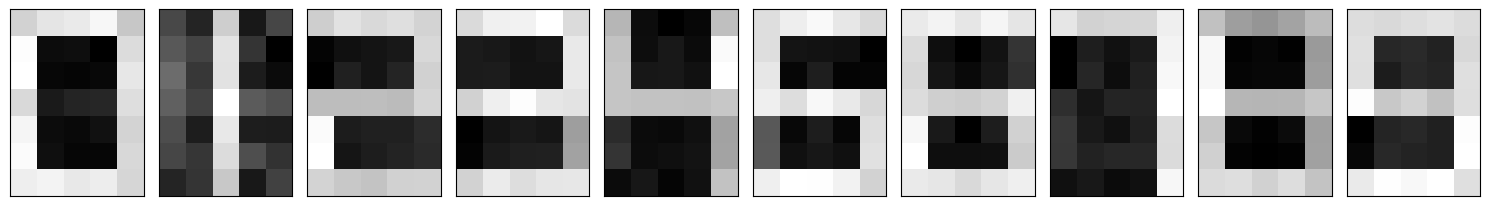

In [8]:
noise_size = 0.5
x_noised = list([xi + np.random.uniform(0, noise_size, img_size) for xi in data_mtrx])
xpred = list([model.predict(xi) for xi in x_noised])

fig1, axes1 = plt.subplots(nrows=1, ncols=10)
fig2, axes2 = plt.subplots(nrows=1, ncols=10)

fig1.set_dpi(100)
fig1.set_figwidth(15)
fig1.set_figheight(5)

fig2.set_dpi(100)
fig2.set_figwidth(15)
fig2.set_figheight(5)

for i, ax in enumerate(axes1.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate(axes2.ravel()):
    ax.imshow(xpred[i].reshape(img_shape),  cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()